In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"


from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

pd.set_option('display.max_columns', 50)

In [2]:
!nvidia-smi

Tue Dec 19 15:13:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| 26%   39C    P8              15W / 125W |    187MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Nov__3_17:51:05_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.3, V12.3.103
Build cuda_12.3.r12.3/compiler.33492891_0


In [4]:
import torch

torch.__version__

'2.1.1+cu121'

In [5]:
import pickle
from pathlib import Path

import cv2
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path, train: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = f"./dataset_dicts_cache{debug_str}.pkl"
    if not use_cache or not Path(cache_path).exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir + "/train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir + "/train" + f"/{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir + "/train" + f"/{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = index
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    # This annotator does not find anything, skip.
                    pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        int(row["x_min"]) * w_ratio,
                        int(row["y_min"]) * h_ratio,
                        int(row["x_max"]) * w_ratio,
                        int(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = imgdir + f"/dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir + "/test" + f"/{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir + "/test" + f"/{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = index
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts

In [6]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content

In [7]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}

In [8]:
# --- flags ---
from dataclasses import dataclass
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results1/det"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    # Training config
    iter: int = 10000
    ims_per_batch: int = 16  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 32

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [9]:
"""
Ref https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=ZyAvNCJMmvFF
"""
import argparse
import dataclasses
import json
import os
import pickle
import random
import sys
from dataclasses import dataclass
from distutils.util import strtobool
from pathlib import Path

import cv2
import detectron2
import numpy as np
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm


setup_logger()


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        # return COCOEvaluator(dataset_name, cfg, True, output_folder)
        return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)

In [10]:
flags_dict = {
    "debug": True,
    "outdir": "results/debug", 
    "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
    "iter": 100,  # debug, small value should be set.
    "roi_batch_size_per_image": 128  # faster, and good enough for this toy dataset (default: 512)
}

In [11]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(Path(flags.outdir + "/flags.yaml"), flags_dict)

# --- Read data ---
datadir = "vinbigdata-256-image-dataset"
imgdir = flags.imgdir_name

# Read in the data CSV files
train = pd.read_csv("vinbigdata-256-image-dataset/vinbigdata/train.csv")
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

DatasetCatalog.register(
    "vinbigdata_train", lambda: get_vinbigdata_dicts(imgdir, train, debug=debug)
)
MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)

torch 2.1.1+cu121
flags Flags(debug=True, outdir='results/debug', imgdir_name='vinbigdata-chest-xray-resized-png-256x256', iter=100, ims_per_batch=16, num_workers=4, base_lr=0.00025, roi_batch_size_per_image=128)


namespace(name='vinbigdata_train',
          thing_classes=['Aortic enlargement',
                         'Atelectasis',
                         'Calcification',
                         'Cardiomegaly',
                         'Consolidation',
                         'ILD',
                         'Infiltration',
                         'Lung Opacity',
                         'Nodule/Mass',
                         'Other lesion',
                         'Pleural effusion',
                         'Pleural thickening',
                         'Pneumothorax',
                         'Pulmonary fibrosis'])

In [12]:
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)

Load from cache ./dataset_dicts_cache_debug1.pkl


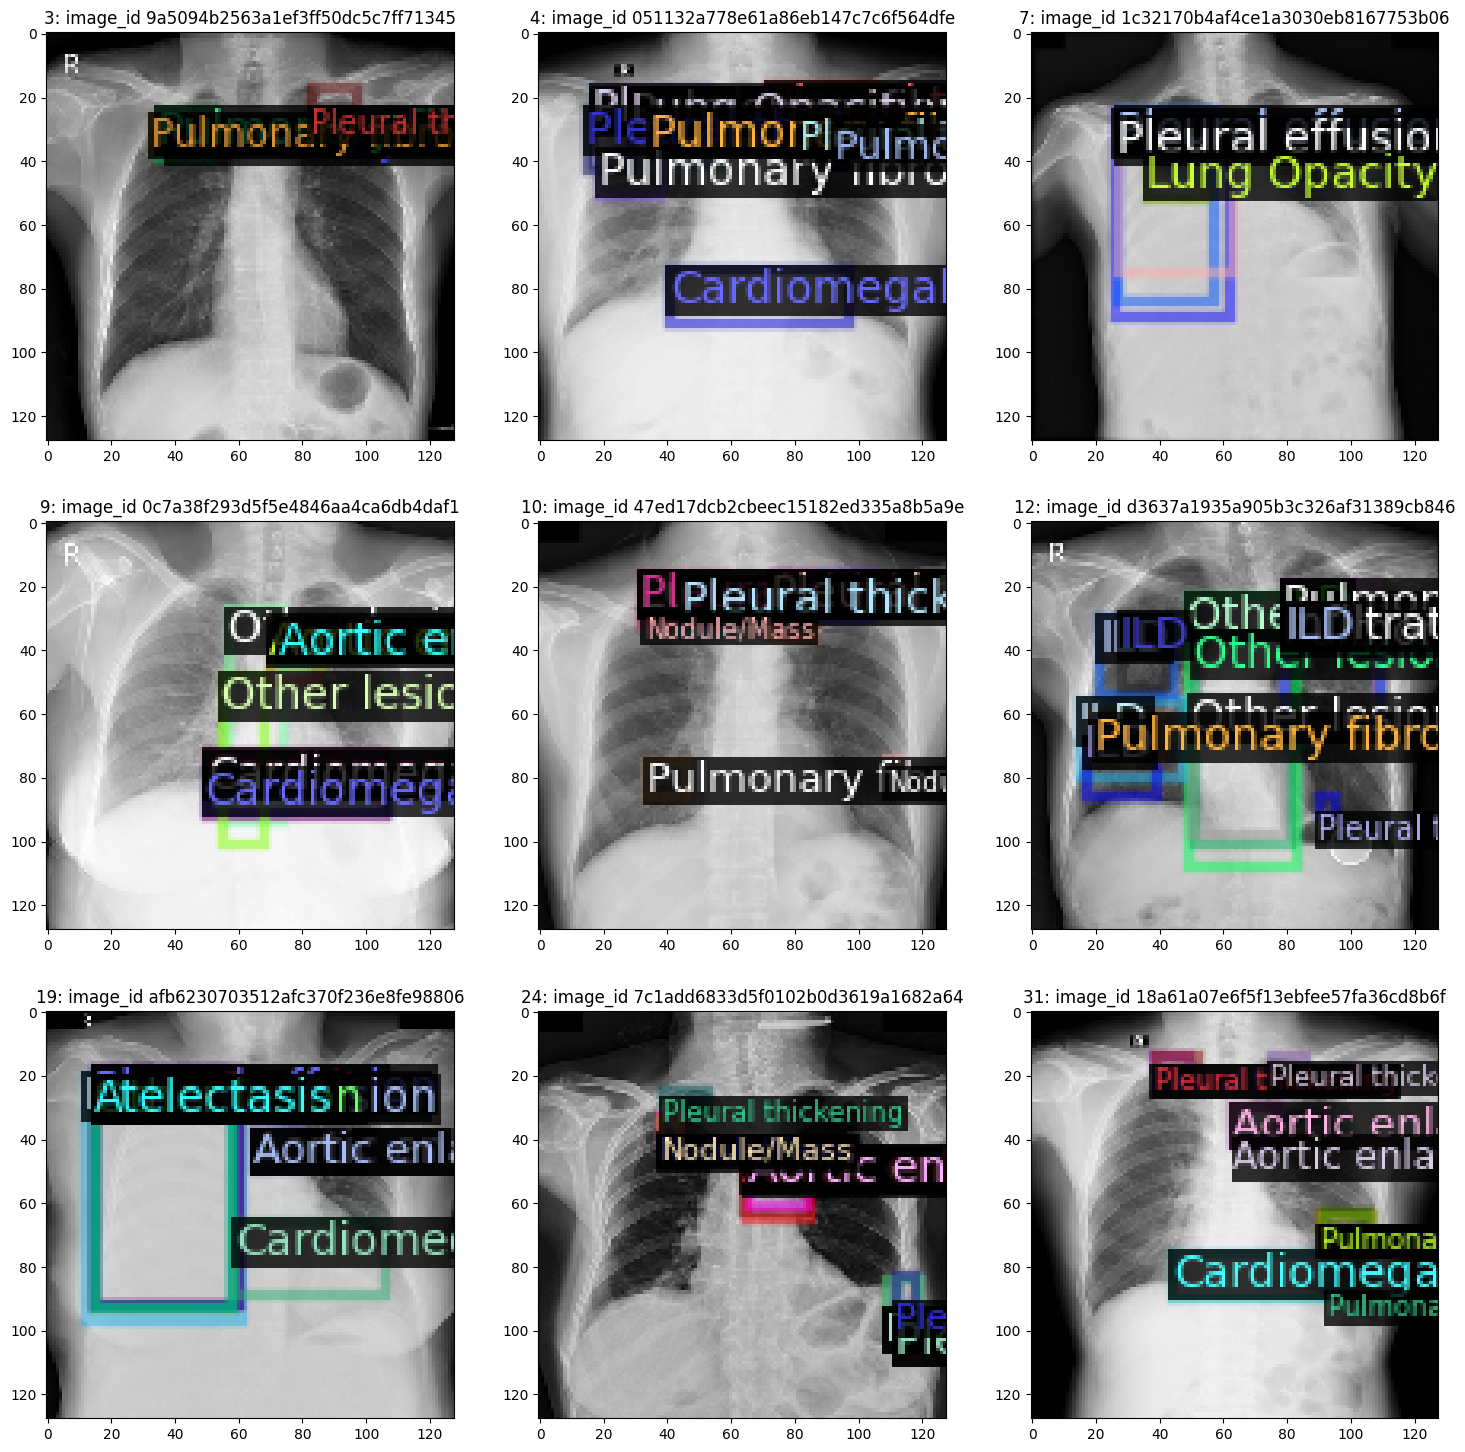

In [13]:
# Visualize data...
anomaly_image_ids = train.query("class_id != 14")["image_id"].unique()
train_meta = pd.read_csv(imgdir+"/train_meta.csv")
anomaly_inds = np.argwhere(train_meta["image_id"].isin(anomaly_image_ids).values)[:, 0]

vinbigdata_metadata = MetadataCatalog.get("vinbigdata_train")

cols = 3
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for index, anom_ind in enumerate(anomaly_inds[:cols * rows]):
    ax = axes[index]
    # print(anom_ind)
    d = dataset_dicts[anom_ind]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vinbigdata_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2_imshow(out.get_image()[:, :, ::-1])
    #cv2.imwrite(str(outdir / f"vinbigdata{index}.jpg"), out.get_image()[:, :, ::-1])
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.set_title(f"{anom_ind}: image_id {anomaly_image_ids[index]}")

In [14]:
cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
cfg.DATASETS.TEST = ()
# cfg.DATASETS.TEST = ("vinbigdata_train",)
# cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

cfg.OUTPUT_DIR ./output -> results\debug
[12/19 15:13:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[12/19 15:13:34 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\alexander.santiago\AppData\Local\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)



[12/19 15:25:15 d2.utils.events]:  eta: 0:44:35  iter: 19  total_loss: 4.048  loss_cls: 2.699  loss_box_reg: 0.3602  loss_rpn_cls: 0.9282  loss_rpn_loc: 0.08459    time: 33.4189  last_time: 32.8643  data_time: 0.5063  last_data_time: 0.0457   lr: 4.7703e-05  max_mem: 10609M
[12/19 15:36:15 d2.utils.events]:  eta: 0:33:26  iter: 39  total_loss: 2.334  loss_cls: 1.444  loss_box_reg: 0.5177  loss_rpn_cls: 0.2839  loss_rpn_loc: 0.08015    time: 33.1743  last_time: 32.1272  data_time: 0.0430  last_data_time: 0.0462   lr: 9.7653e-05  max_mem: 10609M
[12/19 15:46:30 d2.utils.events]:  eta: 0:22:05  iter: 59  total_loss: 1.807  loss_cls: 0.9872  loss_box_reg: 0.5663  loss_rpn_cls: 0.1741  loss_rpn_loc: 0.07159    time: 32.3427  last_time: 30.6003  data_time: 0.0445  last_data_time: 0.0386   lr: 0.0001476  max_mem: 10609M
[12/19 15:57:17 d2.utils.events]:  eta: 0:10:55  iter: 79  total_loss: 1.795  loss_cls: 0.949  loss_box_reg: 0.6232  loss_rpn_cls: 0.1392  loss_rpn_loc: 0.07068    time: 32.33

In [15]:
metrics_df = pd.read_json(outdir / "metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf



,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,rank_data_time,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss
0,0.001261,34.594552,0.033203,0.013158,0.000000,19,0.306947,2.776895,0.806732,0.064618,0.000048,0.001261,111.75000,16.25000,233.00000,23.00000,0.432432,3.939136
20,0.050252,2395.431620,0.102295,0.173579,0.047932,19,0.367918,2.609047,0.847863,0.088534,0.000048,0.050252,109.18750,18.81250,227.34375,28.65625,29.942895,3.840726
25,0.045994,2675.037928,0.052002,0.042282,0.038232,19,0.360183,2.698814,0.928199,0.084586,0.000048,0.045994,109.65625,18.34375,228.81250,27.18750,33.437974,4.048011
5,0.071098,2764.865308,0.020264,0.003393,0.043358,19,0.346661,2.716684,0.865375,0.085489,0.000048,0.071098,109.28125,18.71875,227.75000,28.25000,34.560816,4.050021
15,0.052395,3432.150236,0.130859,0.140190,0.012233,19,0.355084,2.541890,0.820215,0.084571,0.000048,0.052395,109.71875,18.28125,228.09375,27.90625,42.901878,3.882794
10,0.049833,3336.249712,0.009766,0.004793,0.033465,19,0.381441,2.804694,0.903074,0.084899,0.000048,0.049833,109.75000,18.25000,226.71875,29.28125,41.703121,4.132570
21,0.051960,1917.358377,0.811279,1.000000,0.000000,39,0.557220,1.559184,0.333615,0.078903,0.000098,0.051960,103.90625,24.09375,228.37500,27.62500,33.195910,2.529733
16,0.044826,2461.467195,0.816162,1.000000,0.000000,39,0.554277,1.508636,0.305583,0.077558,0.000098,0.044826,104.46875,23.53125,227.71875,28.28125,39.121286,2.431189
26,0.042295,2006.278446,0.817139,1.000000,0.000000,39,0.517731,1.444268,0.283916,0.080146,0.000098,0.042295,104.59375,23.40625,227.71875,28.28125,33.453270,2.334195
11,0.044668,2334.859767,0.808350,1.000000,0.000000,39,0.553207,1.699389,0.298985,0.077563,0.000098,0.044668,104.68750,23.31250,228.84375,27.15625,38.041181,2.603880


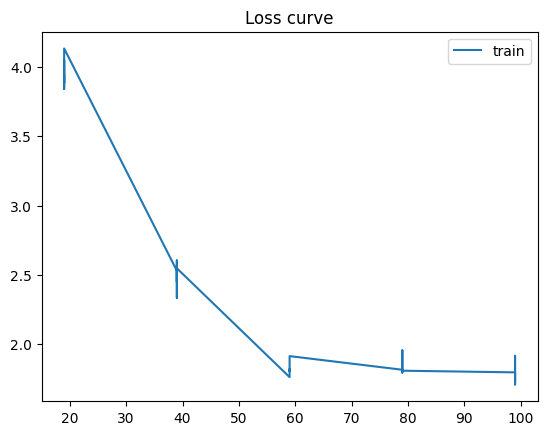

<Figure size 640x480 with 0 Axes>

In [16]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()
plt.savefig(outdir/"loss.png")

KeyError: 'bbox/AP75'

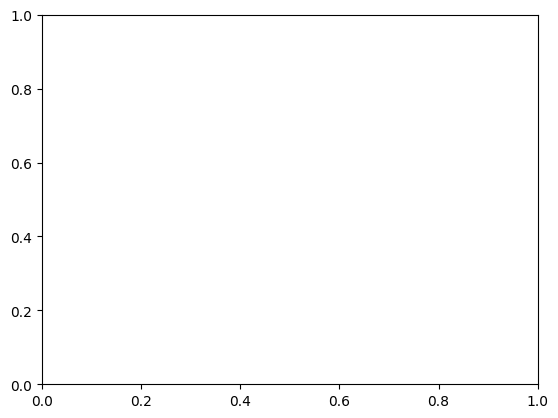

In [17]:
fig, ax = plt.subplots()
mdf3 = mdf[~mdf["bbox/AP75"].isna()]
ax.plot(mdf3["iteration"], mdf3["bbox/AP75"] / 100., c="C2", label="validation")

ax.legend()
ax.set_title("AP40")
plt.show()
plt.savefig(outdir / "AP40.png")

Load from cache ./dataset_dicts_cache_debug1.pkl
[12/20 08:53:24 d2.data.build]: Removed 338 images with no usable annotations. 162 images left.
[12/20 08:53:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/20 08:53:24 d2.data.build]: Using training sampler TrainingSampler
[12/20 08:53:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/20 08:53:24 d2.data.common]: Serializing 162 elements to byte tensors and concatenating them all ...
[12/20 08:53:24 d2.data.common]: Serialized dataset takes 0.11 MiB
[12/20 08:53:24 d2.data.build]: Making batched data loader with batch_size=16
Visualization img (768, 768, 3) saved in results\debug\vinbigdata_0.jpg
Visualization img (736, 736, 3) saved in results\debug\vinbigdata_1.jpg
Visualization img (672, 672, 3) saved in results\debug\vinbi

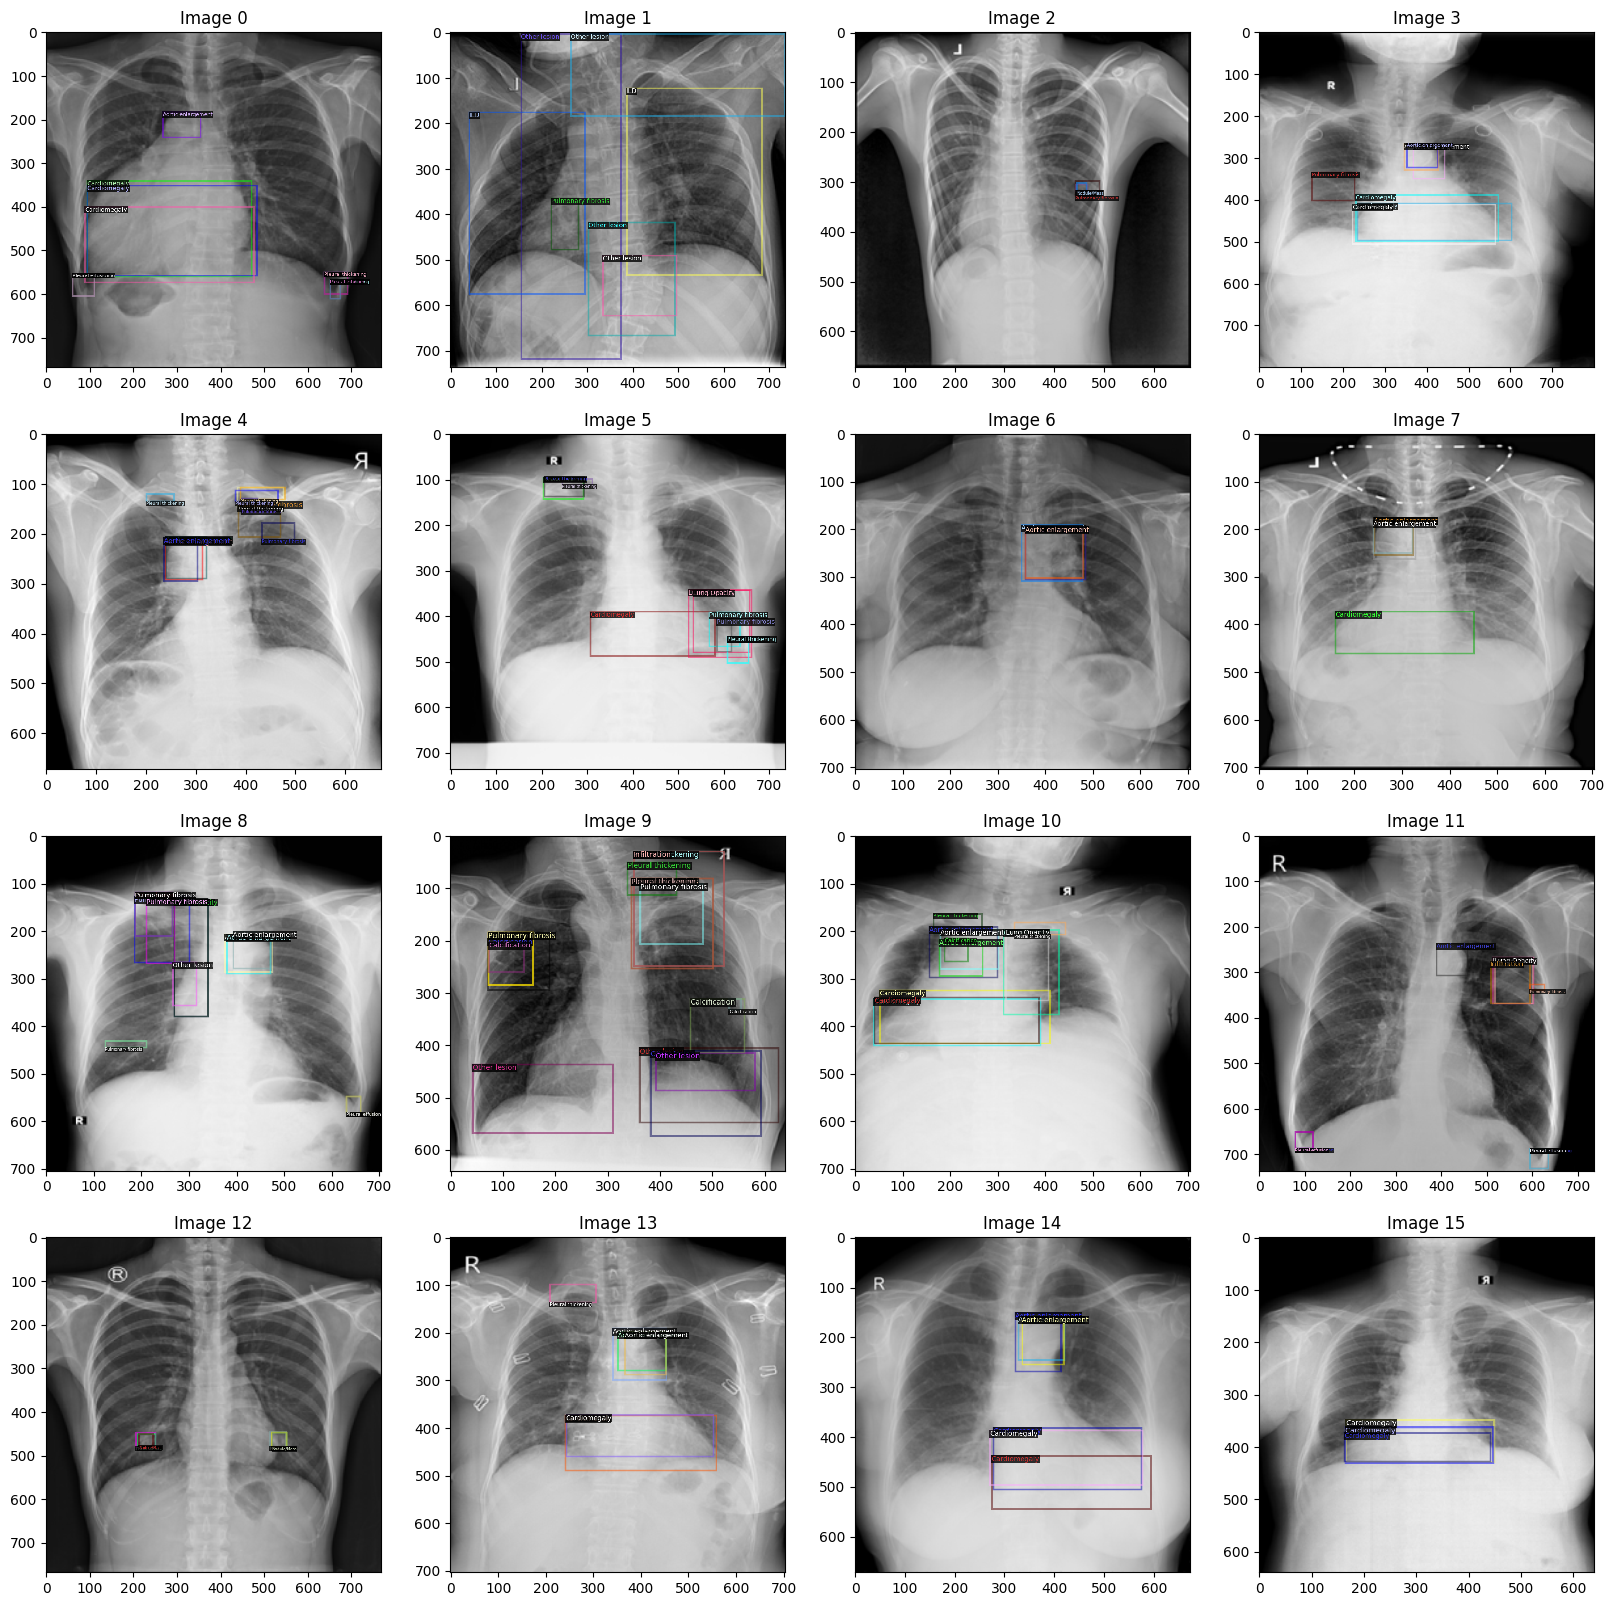

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Path
0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,results\debug\vinbigdata_0.jpg
1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,results\debug\vinbigdata_1.jpg
2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,results\debug\vinbigdata_2.jpg
3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,results\debug\vinbigdata_3.jpg
4,1,0,0,0,0,0,0,0,0,0,0,1,0,1,results\debug\vinbigdata_4.jpg
5,0,0,0,1,0,0,0,1,0,0,1,1,0,1,results\debug\vinbigdata_5.jpg
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,results\debug\vinbigdata_6.jpg
7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,results\debug\vinbigdata_7.jpg
8,1,0,0,0,0,0,0,1,0,1,1,1,0,1,results\debug\vinbigdata_8.jpg
9,0,0,1,0,0,0,1,0,0,1,0,1,0,1,results\debug\vinbigdata_9.jpg


In [21]:
import matplotlib.pyplot as plt
from detectron2.data.samplers import TrainingSampler
from detectron2.utils.visualizer import Visualizer
import pandas as pd

n_images = 16  # Show only one random image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Changed nrows and ncols

sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
train_vis_loader = MyTrainer.build_train_loader(cfg)

list_columns = thing_classes
# print(list_columns)

# Dataframe
df = pd.DataFrame(columns=list_columns + ["Path"])


for batch in train_vis_loader:
    for i, per_image in enumerate(batch):
        row = i // 4 
        col = i % 4 
        ax = axes[row, col]  
        img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))

        visualizer = Visualizer(
            img_arr[:, :, ::-1], metadata=vinbigdata_metadata, scale=1.0
        )
        target_fields = per_image["instances"].get_fields()

        labels = [
            vinbigdata_metadata.thing_classes[i] for i in target_fields["gt_classes"]
        ]

        out = visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=target_fields.get("gt_masks", None),
            keypoints=target_fields.get("gt_keypoints", None),
        )

        img = out.get_image()[:, :, ::-1]
        filepath = str(outdir / f"vinbigdata_{i}.jpg")
        cv2.imwrite(filepath, img)
        print(f"Visualization img {img_arr.shape} saved in {filepath}")
        ax.imshow(img, interpolation='none')
        ax.set_title(f"Image {i}")

        target_classes = target_fields["gt_classes"].tolist()
        mapped_classes = [thing_classes[class_index] for class_index in target_classes]
        mapped_classes = list(set(mapped_classes))
        # print(mapped_classes)
        # Check if mapped class is in corresponding columns
        result_values = [1 if col in mapped_classes else 0 for col in list_columns if col != "Path"]
        # print(result_values)
        
        # Add information to DataFrame
        row_data = result_values
        df.loc[len(df)] = row_data + [filepath]  # Adding filepath separately after matching columns


    plt.show()
    break

df
